# Gerador de Músicas MIDI

O projeto consiste em realizar um estudo no qual serão geradas músicas sem intervenção humana. Para tal, utilizou-se de músicas clássicas de Chopin como dataset e um modelo de Deep Learning.

## Deep Learning - Uma breve introdução

O Deep Learning é um algoritmo de Machine Learning, no qual são utilizadas redes neurais que buscam "aprender" de forma similar ao comportamento humano.

Uma forma simples de entender é imaginar uma criança aprendendo a reconhecer objetos. A criança pode apontar para um objeto e dizer que é um carro. Dado isto, o pai/a mãe da criança pode reagir de duas maneiras: confirmar que o objeto que a criança apontou é um carro, ou falar "Não, isto é um jarro". Ao receber feedback suficiente, a criança começa a internalizar as características de cada objeto e cria um modelo mental que ajuda ela a reconhecer os diferentes objetos. Este modelo depende de uma comunicação efetiva entre os neurônios, transmitindo diferentes sinais e gerando este modelo complexo e hierárquico baseado no feedback recebido.

O Deep Learning busca replicar este comportamento, criando um modelo no qual não é necessário entender cada etapa e decisão feita devido à complexidade e profundidade deste. Para criar o modelo, são utilizadas múltiplas camadas de "neurônios digitais", que vão repassando o aprendizado de camada em camada.

Inicialmente, o modelo é alimentado com os dados a serem utilizados, e este tenta prever os dados, sem nenhuma intervenção. As previsões iniciais irão ser completamente (ou em sua maior parte) incorretas, mas conforme o modelo recebe feedback de suas previões, ele ajusta a comunicação entre seus "neurônios" até ser capaz de gerar previsões mais acuradas.

Existem diversos modelos de Deep Learning, e para o desenvolvimentod este projeto, irá ser utilizado o modelo de WaveNet.

## WaveNet

O WaveNet é um modelo de Deep Learning para áudios "crus" desenvolvido pelo Google DeepMind. Ele é chamado de "generative model", pois tem como objetivo gerar novos samples a partir da distribuição original dos dados. Ele atua de forma similar aos modelos de linguagem utilizados em NLP.

### Treinando o WaveNet

Para treinar o modelo de WaveNet, utiliza-se um trecho de uma onda crua de áudio (no caso, a onda de áudio no domínio do tempo) como input. Uma onda de áudio no domínio do tempo é representada na forma de diferente valores de amplitude em diferentes intervalos de tempo, como é possível visualizar no gif abaixo.

![Onda de áudio no domínio do tempo](https://jvbalen.github.io/figs/wavenet.gif)

A partir da sequência de valores de amplitude, o WaveNet tenta prever qual valor de amplitude vem em seguida. Neste caso, o output depende somente das informações prévias, e não das informações que ainda serão obtidas, o que classifica este modelo como autoregressivo.

In [1]:
# System libraries
from pathlib import Path
from collections import Counter
from itertools import tee

# Numpy for arrays and matplotlib for notes histogram
import numpy as np
import matplotlib.pyplot as plt

# Music21 library for MIDI reading and creating
import music21 as m21
from music21.note import Note
from music21.chord import Chord

# sklearn to split train and test 
from sklearn.model_selection import train_test_split

In [2]:
extracted_folder_path = "chopin/"
threaded = True # Enable threading

In [15]:
train_model = True

if train_model:
    # keras to train the model
    import keras.backend as kb
    import keras.callbacks as kc
    import keras.layers as kl
    import keras.models as km
else:
    # keras to load the model only
    from keras.models import load_model

In [4]:
def read_midi(file):   
    notes = []
    
    # Parsing the MIDI file
    midi = m21.converter.parse(file)
  
    # Partition by instrument
    partition = m21.instrument.partitionByInstrument(midi)

    # Looping over all the instruments
    for part in partition.parts:
        # Select only the piano
        if 'Piano' not in str(part):
            continue

        # Checking if it is a note or a chord
        for element in part.recurse():
            if isinstance(element, Note):
                notes.append(str(element.pitch))

            elif isinstance(element, Chord):
                notes.append('.'.join(map(str, element.normalOrder)))

    return np.array(notes)

In [5]:
files = (p for p in Path(extracted_folder_path).rglob("*") if p.is_file() and p.suffix == ".mid")

if threaded:
    from concurrent.futures import ProcessPoolExecutor

    with ProcessPoolExecutor() as pool:
        notes_list = list(pool.map(read_midi, files))
else:
    notes_list = list(map(read_midi, files))

/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=

/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, trac

In [6]:
# Flattening notes_list
notes_f = np.concatenate(notes_list).ravel()

Number of unique notes: 397


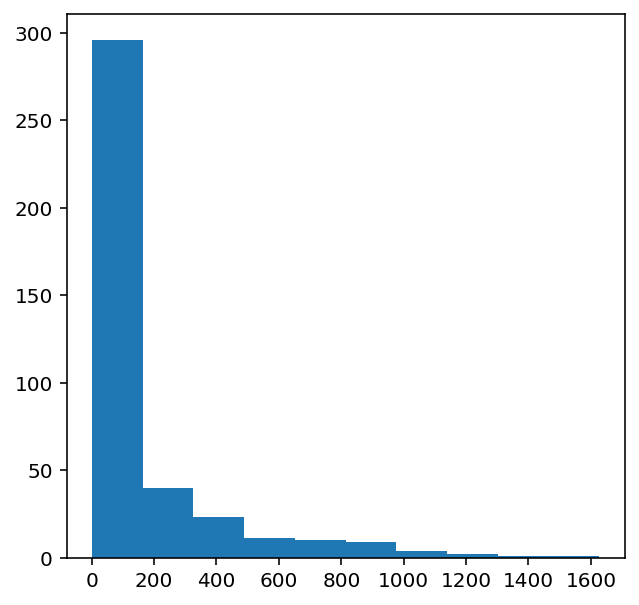

In [7]:
# Get frequency of each note
unique_notes, counts = np.unique(notes_f, return_counts=True)

print(f"Number of unique notes: {len(unique_notes)}")

# Plot histogram
plt.figure(figsize=(5,5))
plt.hist(counts);

In [8]:
# Getting the most frequent notes
frequent_notes = frozenset(unique_notes[counts >= 40])

In [9]:
# Convert note to int and vice-versa

# Use tee to guarantee the iterators are the same
enum_it, rev_enum_it = tee(enumerate(frequent_notes))

# Helper functions
d_int_to_note = dict(enum_it)
int_to_note = lambda idx: d_int_to_note[idx]

d_note_to_int = {note: idx for idx, note in rev_enum_it}
note_to_int = lambda idx: d_note_to_int[idx]

In [10]:
new_music = []

# Adding the most frequent notes
for notes in notes_list:
    new_music.append([d_note_to_int[note] for note in notes if note in frequent_notes])

In [11]:
n_timesteps = 32
X = []
y = []

for note in new_music:
    for start in range(len(note) - n_timesteps):
        end = start + n_timesteps
        X.append(note[start:end])  # Input
        y.append(note[end])        # Output

In [12]:
X_train, X_val, y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.3, random_state=42)

### Arquitetura WaveNet

Os pilares da arquitetura WaveNet estão em suas camadas de rede neural, as quais são chamadas de "Causal Diluted 1D Convolution layers". Mas o que significa isso? Para tal, devemos ir por partes. 

O primeiro conceito importante é o conceito de "convolution": é uma operação matemática na qual é feita uma forma de combinação entre 2 funções. Um exemplo disto é em visão computacional, onde pode ser feita uma combinação linear de uma imagem com um kernel, resultando em uma imagem que possui um filtro. Estendendo este conceito, podemos seguir para a "1D Convolution". Como o nome diz, ela é unidimensional, e nela o kernel/filtro se move em apenas uma direção de modo a gerar um output. A imagem abaixo mostra como um kernel (representado pelos blocos verdes) e um input (representado pelos blocos amarelos) formam um output (representado pelos blocos roxos).

![1D Convolution](https://www.researchgate.net/publication/324177888/figure/fig3/AS:611641670504448@1522838146178/Calculations-involved-in-a-1D-convolution-operation.png)

O output depende do tamanho do kernel, do padding, e do stride. Para este estudo, o mais importante é o padding. O padding é a ideia de possivelmente adicionar zeros à esquerda ou à direita do input de modo a gerar um output com o mesmo tamanho do input. Em 1D Convolution, existem três opções de padding:

- `valid`: sem padding algum;
- `same`: padding simétrico (mesma quantidade de zeros na esquerda e na direita);
- `causal`: adiciona-se zeros **somente** à esquerda do input;

Para nosso estudo, o padding será definido como `causal`, pois assim podemos garantir que nosso modelo depende apenas do dado atual e de dados anteriores, nunca de dados futuros (explicando assim o conceito de Causal 1D Convolution).

Por fim, resta o conceito de Dilated Causal 1D Convolution. O "Dilated" consiste em "furos" ou espaços vazios entre os valores do kernel, de modo intercalado. O número de espaços depende do dilation rate do kernel, que define o chamado reception field da rede (quantidade de inputs que diretamente afetam o output). Para um kernel de tamanho `k` e um dilation rate de tamanho `d`, a nossa camada possui `d-1` espaços entre cada valor do kernel. No gif abaixo é possível ver um exemplo de kernel de tamanho 3x3 com dilation rate de 2 em um input de tamanho 7x7, o que gera um reception field de tamanho 5x5.

![Dilated 1D Causal Convolution](https://miro.medium.com/max/593/0*oX5IPr7TlVM2NpEU.gif)

Para agilizar a convergênca dos dados existem também as conexões Residual e Skip, mas estas não serão utilizadas neste estudo.

In [16]:
if train_model:
    kb.clear_session()
    model = km.Sequential()

    # TODO: Validate x.unique() = frequent_notes
    model.add(kl.Embedding(len(frequent_notes), 100, input_length=32, trainable=True)) 

    model.add(kl.Conv1D(64, 3, padding='causal',activation='relu'))
    model.add(kl.Dropout(0.2))
    model.add(kl.MaxPool1D(2))

    model.add(kl.Conv1D(128, 3, activation='relu', dilation_rate=2, padding='causal'))
    model.add(kl.Dropout(0.2))
    model.add(kl.MaxPool1D(2))

    model.add(kl.Conv1D(256, 3, activation='relu', dilation_rate=4, padding='causal'))
    model.add(kl.Dropout(0.2))
    model.add(kl.MaxPool1D(2))

    model.add(kl.GlobalMaxPool1D())

    model.add(kl.Dense(256, activation='relu'))
    # TODO: Validate y.unique() = frequent_notes
    model.add(kl.Dense(len(frequent_notes), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           16900     
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

2021-12-08 10:48:03.812603: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 10:48:03.814602: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
if train_model:
    mc = kc.ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), verbose=1, callbacks=[mc])
else:
    model = load_model('model.h5')

Epoch 1/50
298/298 [==============================] - ETA: 0s - loss: 4.5264
Epoch 00001: val_loss improved from inf to 4.31399, saving model to model.h5
298/298 [==============================] - 24s 79ms/step - loss: 4.5264 - val_loss: 4.3140
Epoch 2/50
298/298 [==============================] - ETA: 0s - loss: 4.0785
Epoch 00002: val_loss improved from 4.31399 to 4.12130, saving model to model.h5
298/298 [==============================] - 25s 84ms/step - loss: 4.0785 - val_loss: 4.1213
Epoch 3/50
298/298 [==============================] - ETA: 0s - loss: 3.8813
Epoch 00003: val_loss improved from 4.12130 to 3.93952, saving model to model.h5
298/298 [==============================] - 25s 84ms/step - loss: 3.8813 - val_loss: 3.9395
Epoch 4/50
298/298 [==============================] - ETA: 0s - loss: 3.7559
Epoch 00004: val_loss improved from 3.93952 to 3.87370, saving model to model.h5
298/298 [==============================] - 25s 85ms/step - loss: 3.7559 - val_loss: 3.8737
Epoch 5/

Epoch 34/50
298/298 [==============================] - ETA: 0s - loss: 2.6022
Epoch 00034: val_loss improved from 3.17809 to 3.17152, saving model to model.h5
298/298 [==============================] - 26s 87ms/step - loss: 2.6022 - val_loss: 3.1715
Epoch 35/50
298/298 [==============================] - ETA: 0s - loss: 2.5924
Epoch 00035: val_loss did not improve from 3.17152
298/298 [==============================] - 25s 83ms/step - loss: 2.5924 - val_loss: 3.1721
Epoch 36/50
297/298 [============================>.] - ETA: 0s - loss: 2.5802
Epoch 00036: val_loss improved from 3.17152 to 3.16906, saving model to model.h5
298/298 [==============================] - 25s 85ms/step - loss: 2.5805 - val_loss: 3.1691
Epoch 37/50
298/298 [==============================] - ETA: 0s - loss: 2.5692
Epoch 00037: val_loss improved from 3.16906 to 3.15160, saving model to model.h5
298/298 [==============================] - 25s 85ms/step - loss: 2.5692 - val_loss: 3.1516
Epoch 38/50
298/298 [=========

### Gerando novas samples

Para gerar uma música com samples anteriores, basta seguir a lógica abaixo:

1. Selecionar um array com diferentes valores de samples como ponto de início
2. O modelo calcula a distribuição de probabilidades de todas as samples
3. O modelo obtém a sample com maior probabilidade e coloca ela no final do array
4. Remove-se o primeiro elemento do array e reinsere-se o novo array como input
5. Repetem-se os passos 2 a 4 por um número `n` de iterações

In [18]:
idx = np.random.randint(0, X_val.shape[0] - 1)

random_music = X_val[idx]
predictions = []

for i in range(10):
    random_music = random_music.reshape(1, n_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred = np.argmax(prob, axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
    random_music = random_music[1:]

print(predictions)

[53, 53, 53, 53, 53, 142, 1, 142, 1, 55]


In [19]:
# Deleting previously generated MIDI file, if any
midi_file = "music.mid"
Path(midi_file).unlink(missing_ok=True)

In [20]:
def convert_to_midi(prediction_output, mf):
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for offset, pattern in enumerate(prediction_output):
        # pattern is a chord
        if '.' in pattern or pattern.isdigit():
            notes = []
            
            for current_note in pattern.split('.'):
                new_note = Note(int(current_note))
                new_note.storedInstrument = m21.instrument.Piano()
                notes.append(new_note)
                
            new_chord = Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)

        # pattern is a note
        else:
            new_note = Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = m21.instrument.Piano()
            output_notes.append(new_note)

    midi_stream = m21.stream.Stream(output_notes)
    midi_stream.write('midi', fp=mf)

In [21]:
# Creating MIDI file
convert_to_midi(map(int_to_note, predictions), midi_file)

# Shows MIDI in player
# https://stackoverflow.com/questions/57021743/how-to-play-audio-inline-using-ipython-display-audio
mf = m21.midi.MidiFile()
mf.open(midi_file)
mf.read()
mf.close()
s = m21.midi.translate.midiFileToStream(mf)
s.show('midi')

## Conclusões

O modelo foi capaz de gerar um trecho de notas musicais que remetem parcialmente a ideia de uma música. O uso de músicas de um mesmo compositor/artista e do mesmo gênero ajuda neste processo, pois não há o risco de confundir o modelo com muitos dados diferentes.

No entanto, algumas notas se encontram com muita frequência, o que é presente no output. Em casos de músicas de input que não possuem muita variedade de notas/repetem muitas vezes certas notas, o modelo pode gerar algo que não soa como uma música.

O ponto mais importante é que o conceito de música é subjetivo, e nem sempre utilizar as notas com maior probabilidade pode gerar uma música agradável ao ouvido humano.

Para próximas iterações, pode-se aprimorar o modelo para utilizar mais de um instrumento para determinar as notas frequentes, de modo que eles interajam entre si. Pode-se também gerar alterações na lógica para considerar outros fatores além da alta probabilidade de uma nota musical.

## Bibliografia

[Recurrent Neural Networks](https://www.slideshare.net/xavigiro/recurrent-neural-networks-2-d2l3-deep-learning-for-speech-and-language-upc-2017)  
[WaveNet: A Generative Model for Raw Audio](https://arxiv.org/pdf/1609.03499.pdf)  
[Keras API](https://keras.io/api/)  
[music21 documentation](https://web.mit.edu/music21/doc/index.html)  